# Temperature Signal Decomposition - Real Data Analysis

Comparing decomposition methods on 2024 temperature data:
- **Butterworth** bandpass filter
- **SavGol + Butterworth** cleanup
- **STL** (LOESS-based)

Data: 15-min temperature readings for full year 2024 (~35K observations)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from signal_decomposer_v3 import SignalDecomposer
from stl_decomposer import STLDecomposer

plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['font.size'] = 10

freq = 96  # 15-min data = 96 obs/day

## 1. Load and Explore Data

In [2]:
# Load data
df = pd.read_csv('../data/temp2024.csv')
df['ds'] = pd.to_datetime(df['ds'], utc=True).dt.tz_convert('America/Santiago')
df = df[['ds', 'y']].copy()

print(f"Data shape: {df.shape}")
print(f"Date range: {df['ds'].min()} to {df['ds'].max()}")
print(f"NaN values: {df['y'].isna().sum()} ({df['y'].isna().mean()*100:.1f}%)")
print(f"\nTemperature stats:")
print(df['y'].describe())

Data shape: (35136, 2)
Date range: 2024-01-01 00:15:00-03:00 to 2025-01-01 00:00:00-03:00
NaN values: 1501 (4.3%)

Temperature stats:
count    33635.000000
mean        10.717107
std          5.528054
min         -7.793406
25%          7.139533
50%         11.580995
75%         14.910625
max         22.983095
Name: y, dtype: float64


## 2. Multi-Scale Visualization

View the raw temperature at different time scales.

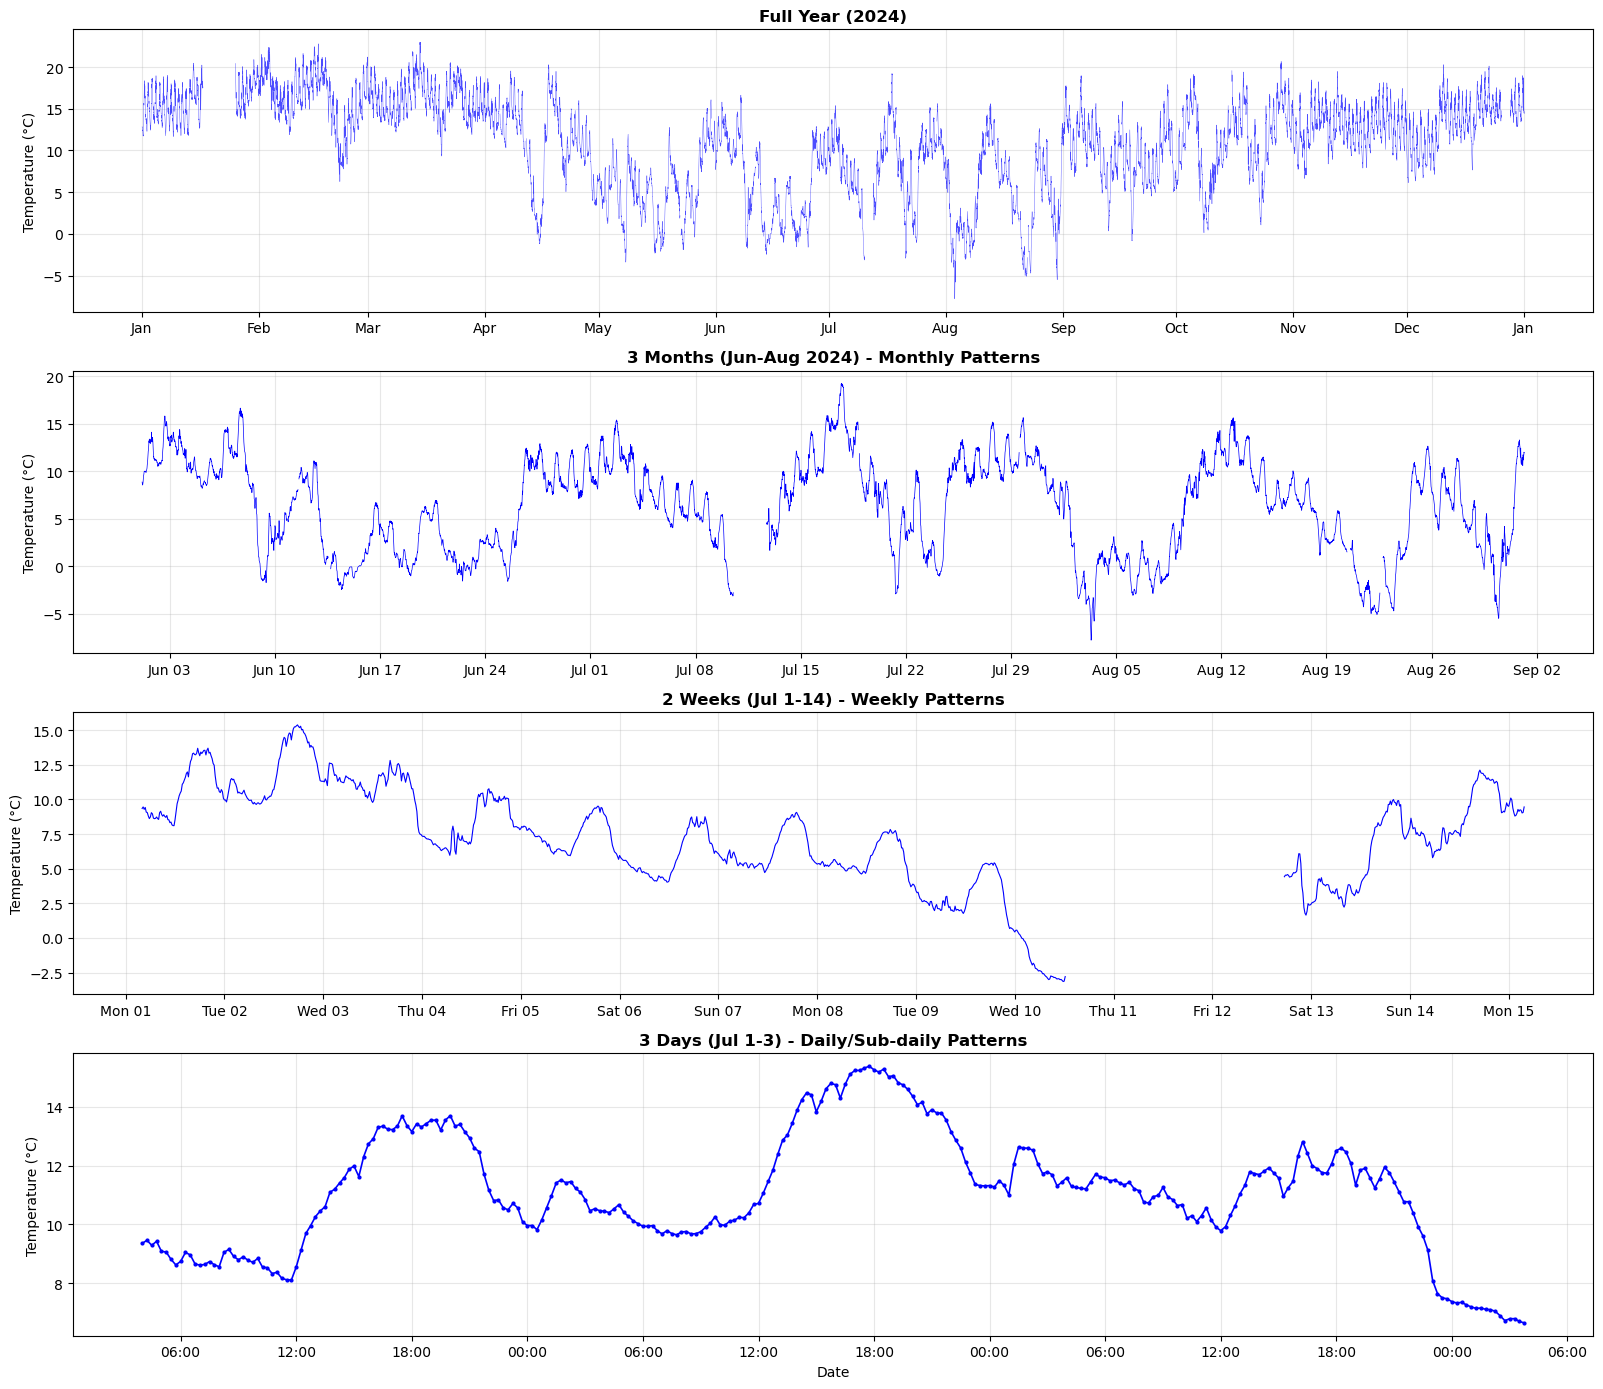

In [3]:
fig, axes = plt.subplots(4, 1, figsize=(16, 14))

# Full year
axes[0].plot(df['ds'], df['y'], 'b-', lw=0.3, alpha=0.7)
axes[0].set_title('Full Year (2024)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temperature (°C)')
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# 3 months (quarterly scale)
q1_mask = (df['ds'] >= '2024-06-01') & (df['ds'] < '2024-09-01')
axes[1].plot(df.loc[q1_mask, 'ds'], df.loc[q1_mask, 'y'], 'b-', lw=0.5)
axes[1].set_title('3 Months (Jun-Aug 2024) - Monthly Patterns', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Temperature (°C)')
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# 2 weeks (weekly scale)
w_mask = (df['ds'] >= '2024-07-01') & (df['ds'] < '2024-07-15')
axes[2].plot(df.loc[w_mask, 'ds'], df.loc[w_mask, 'y'], 'b-', lw=0.8)
axes[2].set_title('2 Weeks (Jul 1-14) - Weekly Patterns', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Temperature (°C)')
axes[2].xaxis.set_major_locator(mdates.DayLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%a %d'))

# 3 days (daily scale)
d_mask = (df['ds'] >= '2024-07-01') & (df['ds'] < '2024-07-04')
axes[3].plot(df.loc[d_mask, 'ds'], df.loc[d_mask, 'y'], 'b-', lw=1.2, marker='o', markersize=2)
axes[3].set_title('3 Days (Jul 1-3) - Daily/Sub-daily Patterns', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Temperature (°C)')
axes[3].set_xlabel('Date')
axes[3].xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

## 3. Apply Decomposition Methods

In [4]:
# Period configuration
period_pairs = [
    (0.25, 0.75),   # Sub-daily (6-18 hours)
    (0.75, 3.0),   # Daily (18-30 hours)
    (3.0, 7.0),     # Weekly (1.5-7 days)
    (7.0, 21.0),    # Monthly (7-30 days)
    (21.0, 120.0),  # Trend (30-180 days)
]

stl_periods = [0.5, 1.0, 7.0, 28.0]

print("Period configuration:")
print(f"  Butterworth/SavGol pairs: {period_pairs}")
print(f"  STL periods: {stl_periods}")

Period configuration:
  Butterworth/SavGol pairs: [(0.25, 0.75), (0.75, 3.0), (3.0, 7.0), (7.0, 21.0), (21.0, 120.0)]
  STL periods: [0.5, 1.0, 7.0, 28.0]


In [5]:
# 1. Butterworth
decomposer_bw = SignalDecomposer(
    freq=freq,
    period_pairs=period_pairs,
    filter_type='butterworth',
    butter_order=4,
    edge_method='symmetric',
    edge_pad_periods=2.0,
    mode='keep'
)
df_bw = decomposer_bw.decompose(df.copy())

Filled 674 NaN values using periodic fill (period=1.0d)

Signal Decomposition - BUTTERWORTH
Data frequency: 96 obs/day
Data length: 35136 observations (366.0 days)
NaN handling: periodic (period=1.0d)
Edge method: symmetric (pad=2.0 periods)
Edge weighting: False
Number of bands: 5

Computing band_0 (0.25-0.75d, freqs=[0.0278, 0.0833], pad=144)...
Computing band_1 (0.75-3.00d, freqs=[0.0069, 0.0278], pad=576)...
Computing band_2 (3.00-7.00d, freqs=[0.0030, 0.0069], pad=1344)...
Computing band_3 (7.00-21.00d, freqs=[0.0010, 0.0030], pad=4032)...
Computing band_4 (21.00-120.00d, freqs=[0.0008, 0.0012], pad=23040)...

Decomposition complete. Shape: (35136, 7)



/Users/esteves/Documents/github/RubinsOracle/examples/signal_decomposer_v3.py:89: UserWarning: Gap at index 1547-2373 (827 points) exceeds max_gap_periods=7. Skipping.
  warnings.warn(


In [6]:
# 2. SavGol + Butterworth cleanup
decomposer_sg = SignalDecomposer(
    freq=freq,
    period_pairs=period_pairs,
    filter_type='savgol',
    savgol_polyorder=3,
    savgol_butter_cleanup=True,
    savgol_butter_margin=0.1,
    edge_method='symmetric',
    edge_pad_periods=2.0,
    mode='keep'
)
df_sg = decomposer_sg.decompose(df.copy())

/Users/esteves/Documents/github/RubinsOracle/examples/signal_decomposer_v3.py:89: UserWarning: Gap at index 1547-2373 (827 points) exceeds max_gap_periods=7. Skipping.
  warnings.warn(


Filled 674 NaN values using periodic fill (period=1.0d)

Signal Decomposition - SAVGOL
Data frequency: 96 obs/day
Data length: 35136 observations (366.0 days)
NaN handling: periodic (period=1.0d)
Edge method: symmetric (pad=2.0 periods)
Edge weighting: False
Number of bands: 5

Computing band_0 (0.25-0.75d, windows=[37, 109], pad=144)...
Computing band_1 (0.75-3.00d, windows=[109, 433], pad=576)...
Computing band_2 (3.00-7.00d, windows=[433, 1009], pad=1344)...
Computing band_3 (7.00-21.00d, windows=[1009, 3025], pad=4032)...
Computing band_4 (21.00-120.00d, windows=[3025, 17281], pad=23040)...

Decomposition complete. Shape: (35136, 7)



In [7]:
# 3. STL
decomposer_stl = STLDecomposer(
    freq=freq,
    periods=stl_periods,
    # edge_method='reflect',
    # edge_pad_periods=2.0,
    robust=False,
    mode='keep'
)
df_stl = decomposer_stl.decompose(df.copy())


Signal Decomposition - STL (LOESS) Method
Data frequency: 96 obs/day
Data length: 35136 observations (366.0 days)
Periods to extract: [0.5, 1.0, 7.0, 28.0] days
Robust: False

Computing period_0.5d (period=0.5d, 48 obs)...
  → Extracted seasonal (std=0.4787)
Computing period_1.0d (period=1.0d, 96 obs)...
  → Extracted seasonal (std=1.2817)
Computing period_7.0d (period=7.0d, 672 obs)...
  → Extracted seasonal (std=0.3424)
Computing period_28.0d (period=28.0d, 2688 obs)...
  → Extracted seasonal (std=1.0864)
Computing trend (remaining signal)...
  → Trend (std=5.3346)

Decomposition complete. Dataset shape: (35136, 7)



## 4. Trend Comparison (Full Year)

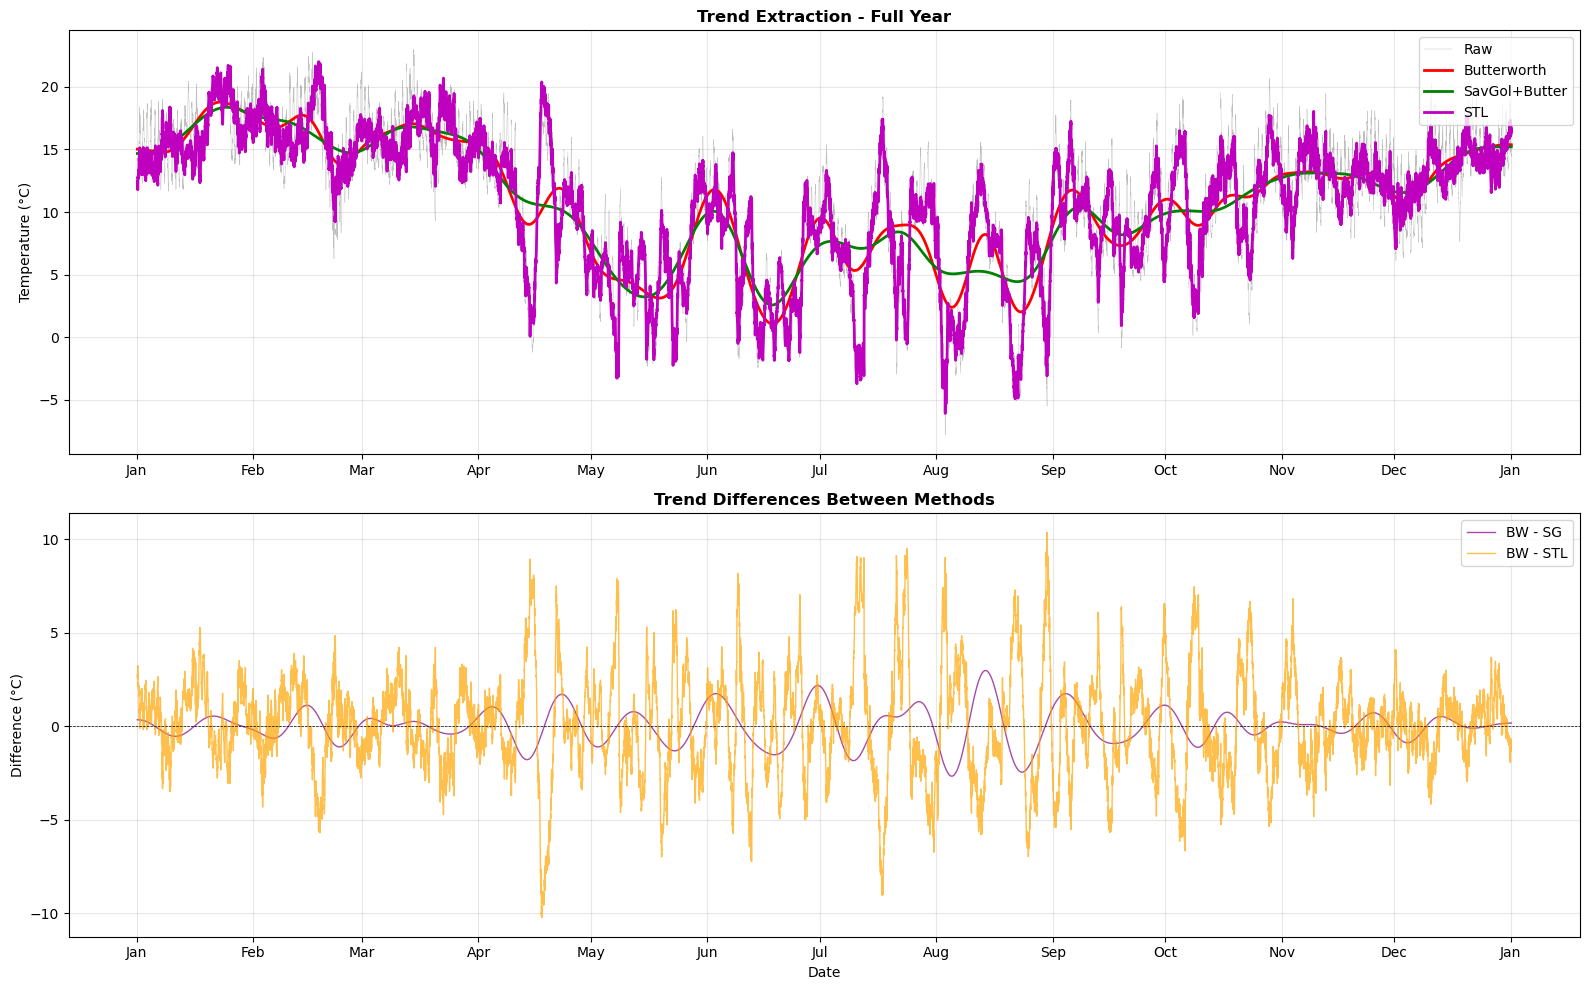

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Raw signal with trend overlay
axes[0].plot(df_bw['ds'], df_bw['y'], 'gray', lw=0.3, alpha=0.5, label='Raw')
axes[0].plot(df_bw['ds'], df_bw['y_band_4'], 'r-', lw=2, label='Butterworth')
axes[0].plot(df_sg['ds'], df_sg['y_band_4'], 'g-', lw=2, label='SavGol+Butter')
axes[0].plot(df_stl['ds'], df_stl['y_trend'], 'm-', lw=2, label='STL')
axes[0].set_title('Trend Extraction - Full Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend(loc='upper right')
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Trend differences
axes[1].plot(df_bw['ds'], df_bw['y_band_4'] - df_sg['y_band_4'].values, 'purple', lw=1, label='BW - SG', alpha=0.7)
axes[1].plot(df_bw['ds'], df_bw['y_band_4'] - df_stl['y_trend'].values, 'orange', lw=1, label='BW - STL', alpha=0.7)
axes[1].axhline(0, color='k', linestyle='--', lw=0.5)
axes[1].set_title('Trend Differences Between Methods', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Difference (°C)')
axes[1].set_xlabel('Date')
axes[1].legend(loc='upper right')
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

## 5. Monthly Component (7-30 day cycles)

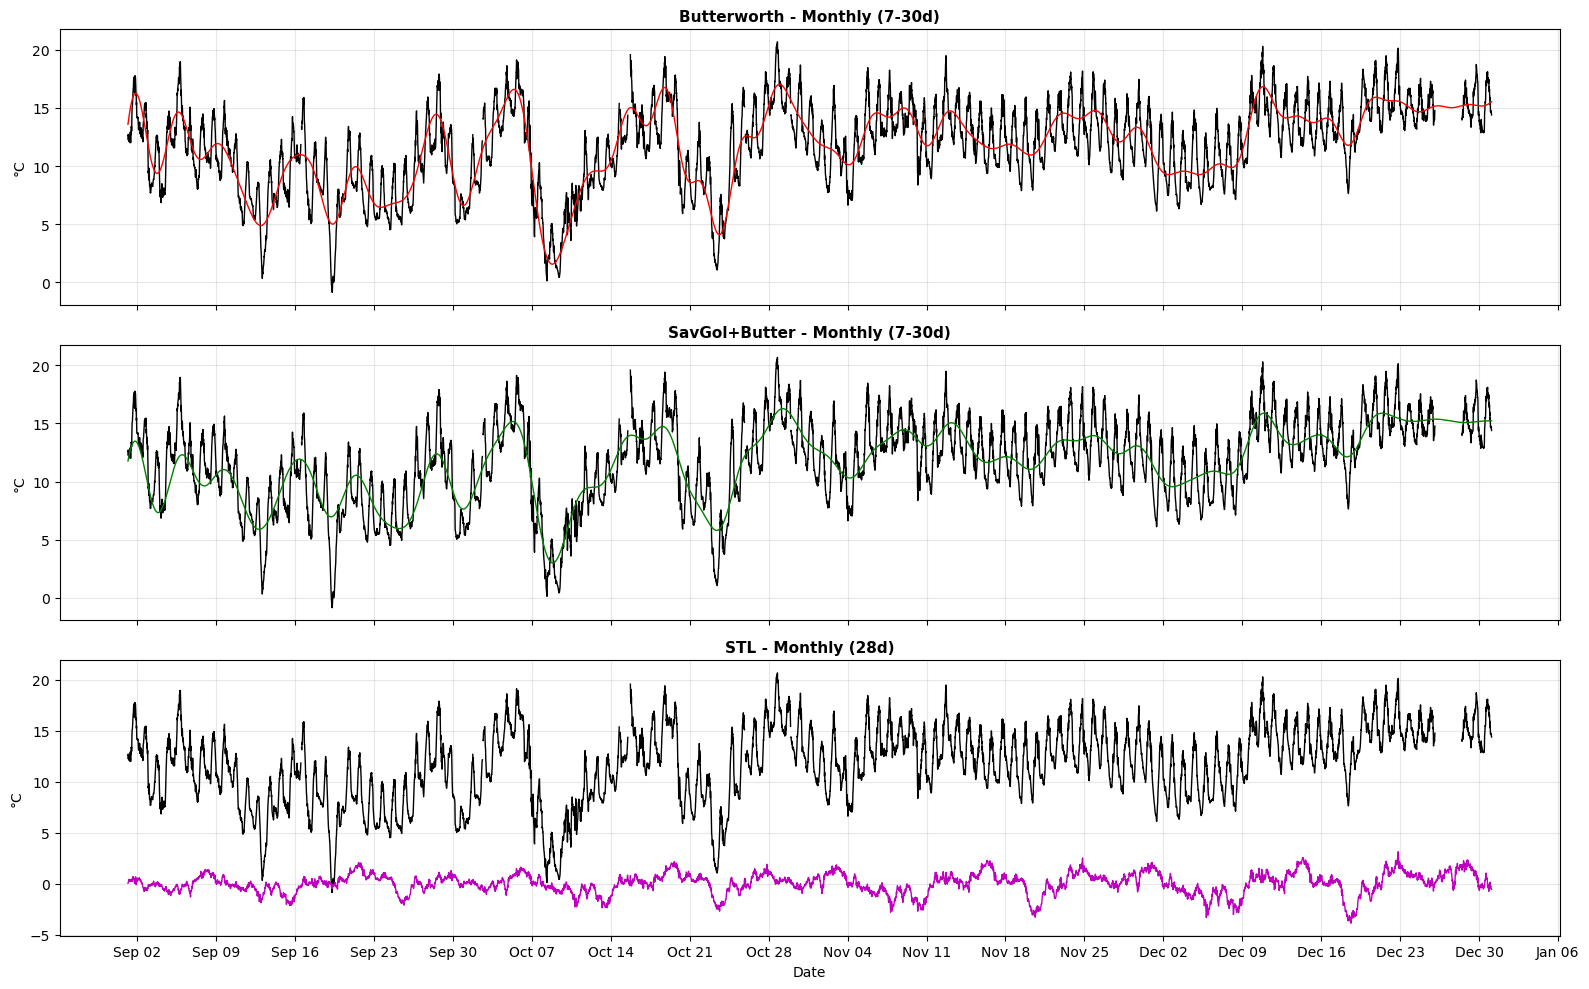

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# 3-month window for better visualization
mask = (df_bw['ds'] >= '2024-09-01') & (df_bw['ds'] < '2024-12-31')

for i in range(3):
    axes[i].plot(df.loc[mask, 'ds'], df.loc[mask, 'y'], 'k-', lw=1)

axes[0].plot(df_bw.loc[mask, 'ds'], df_bw.loc[mask, 'y_band_4']+df_bw.loc[mask, 'y_band_3']+df_bw.loc[mask, 'y_band_2'], 'r-', lw=1)
axes[0].set_title('Butterworth - Monthly (7-30d)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('°C')

axes[1].plot(df_sg.loc[mask, 'ds'], df_sg.loc[mask, 'y_band_4']+ df_sg.loc[mask, 'y_band_3']+df_sg.loc[mask, 'y_band_2'], 'g-', lw=1)
axes[1].set_title('SavGol+Butter - Monthly (7-30d)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('°C')

axes[2].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y_period_28.0d']+df_stl.loc[mask, 'y_period_7.0d'], 'm-', lw=1)
axes[2].set_title('STL - Monthly (28d)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('°C')
axes[2].set_xlabel('Date')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.show()

## 6. Weekly Component (1.5-7 day cycles)

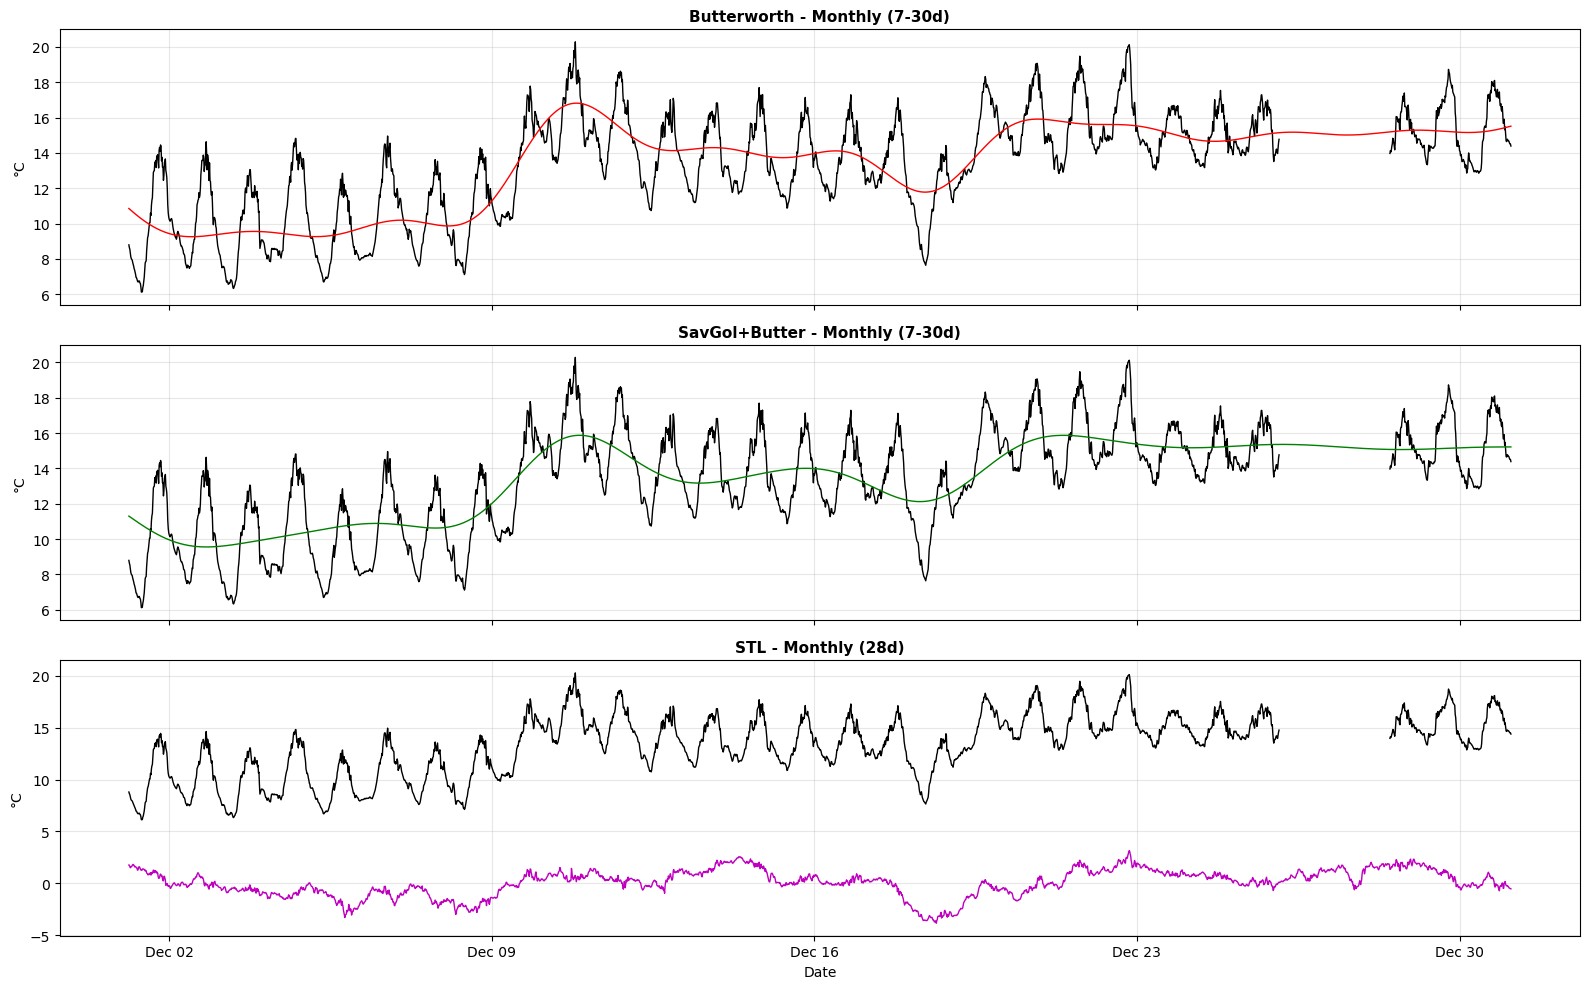

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# 3-month window for better visualization
mask = (df_bw['ds'] >= '2024-12-01') & (df_bw['ds'] < '2024-12-31')

for i in range(3):
    axes[i].plot(df.loc[mask, 'ds'], df.loc[mask, 'y'], 'k-', lw=1)

axes[0].plot(df_bw.loc[mask, 'ds'], df_bw.loc[mask, 'y_band_4']+df_bw.loc[mask, 'y_band_3']+df_bw.loc[mask, 'y_band_2'], 'r-', lw=1)
axes[0].set_title('Butterworth - Monthly (7-30d)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('°C')

axes[1].plot(df_sg.loc[mask, 'ds'], df_sg.loc[mask, 'y_band_4']+ df_sg.loc[mask, 'y_band_3']+df_sg.loc[mask, 'y_band_2'], 'g-', lw=1)
axes[1].set_title('SavGol+Butter - Monthly (7-30d)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('°C')

axes[2].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y_period_28.0d']+df_stl.loc[mask, 'y_period_7.0d'], 'm-', lw=1)
axes[2].set_title('STL - Monthly (28d)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('°C')
axes[2].set_xlabel('Date')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.show()

## 7. Daily Component (18-30 hour cycles)

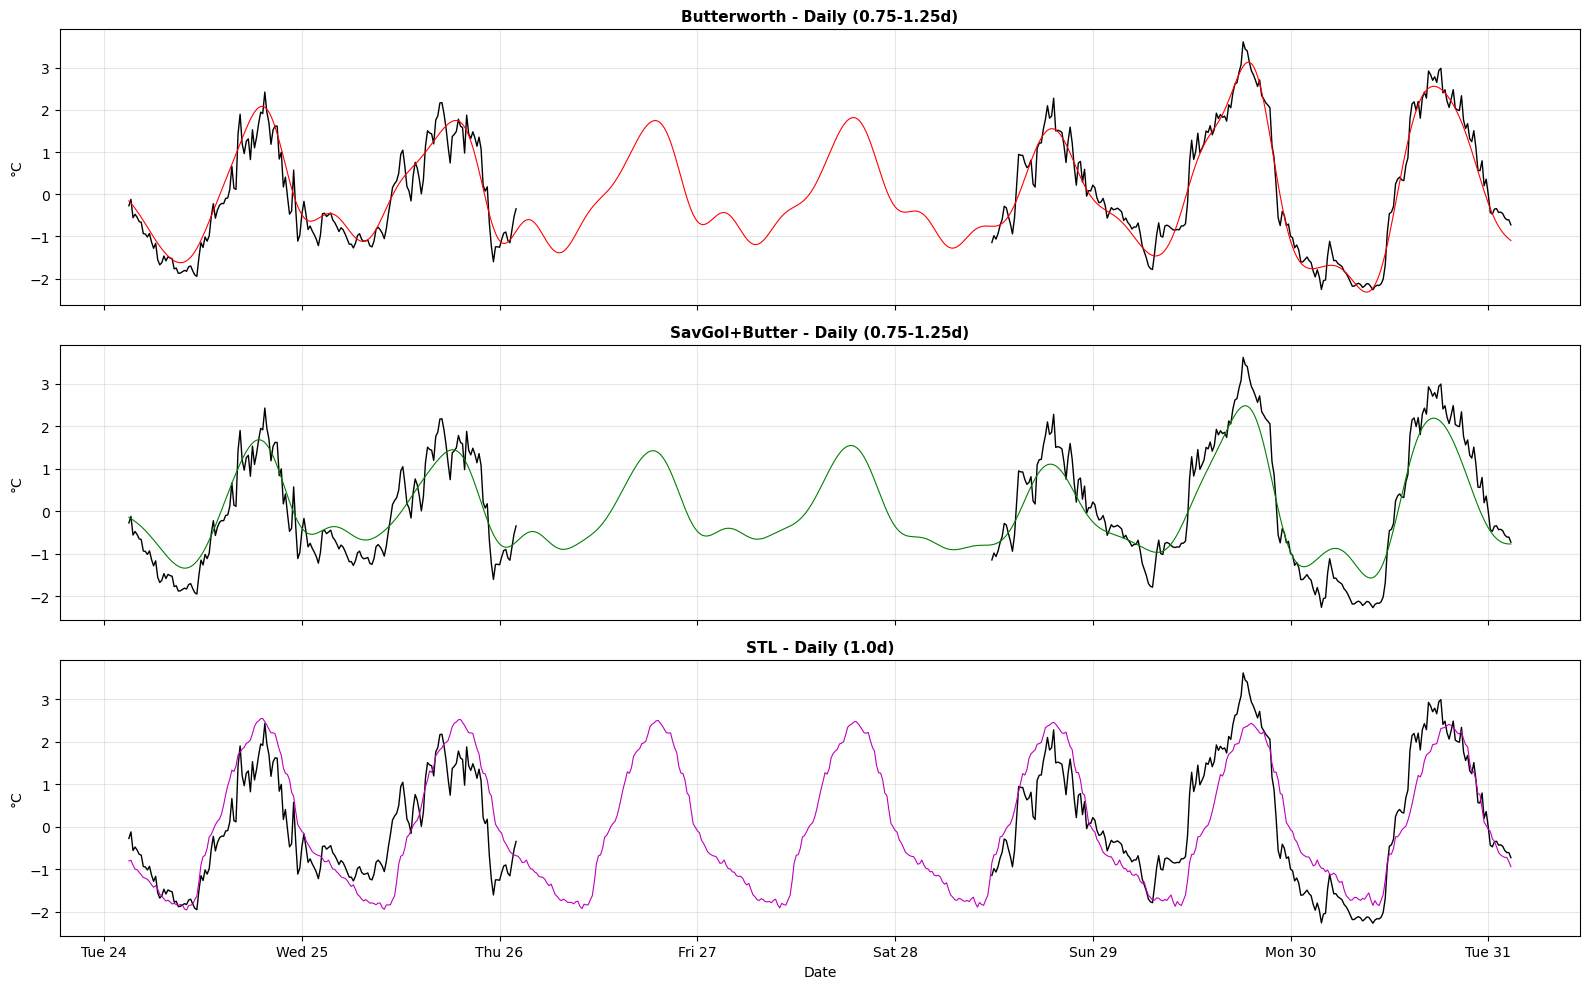

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# 2-week window
mask = (df_bw['ds'] >= '2024-12-24') & (df_bw['ds'] < '2024-12-31')

for i in range(3):
    axes[i].plot(df.loc[mask, 'ds'], df.loc[mask, 'y'] -  df.loc[mask, 'y'].iloc[-300:].median(), 'k-', lw=1)

axes[0].plot(df_bw.loc[mask, 'ds'], df_bw.loc[mask, 'y_band_1']+df_bw.loc[mask, 'y_band_0'], 'r-', lw=0.8)
axes[0].set_title('Butterworth - Daily (0.75-1.25d)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('°C')

axes[1].plot(df_sg.loc[mask, 'ds'], df_sg.loc[mask, 'y_band_1']+df_sg.loc[mask, 'y_band_0'], 'g-', lw=0.8)
axes[1].set_title('SavGol+Butter - Daily (0.75-1.25d)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('°C')

axes[2].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y_period_1.0d']+df_stl.loc[mask, 'y_period_0.5d'], 'm-', lw=0.8)
axes[2].set_title('STL - Daily (1.0d)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('°C')
axes[2].set_xlabel('Date')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d'))

plt.tight_layout()
plt.savefig('./real_data_decomposition_daily.png', dpi=120)
plt.show()

## 8. Sub-daily Component (6-18 hour cycles)

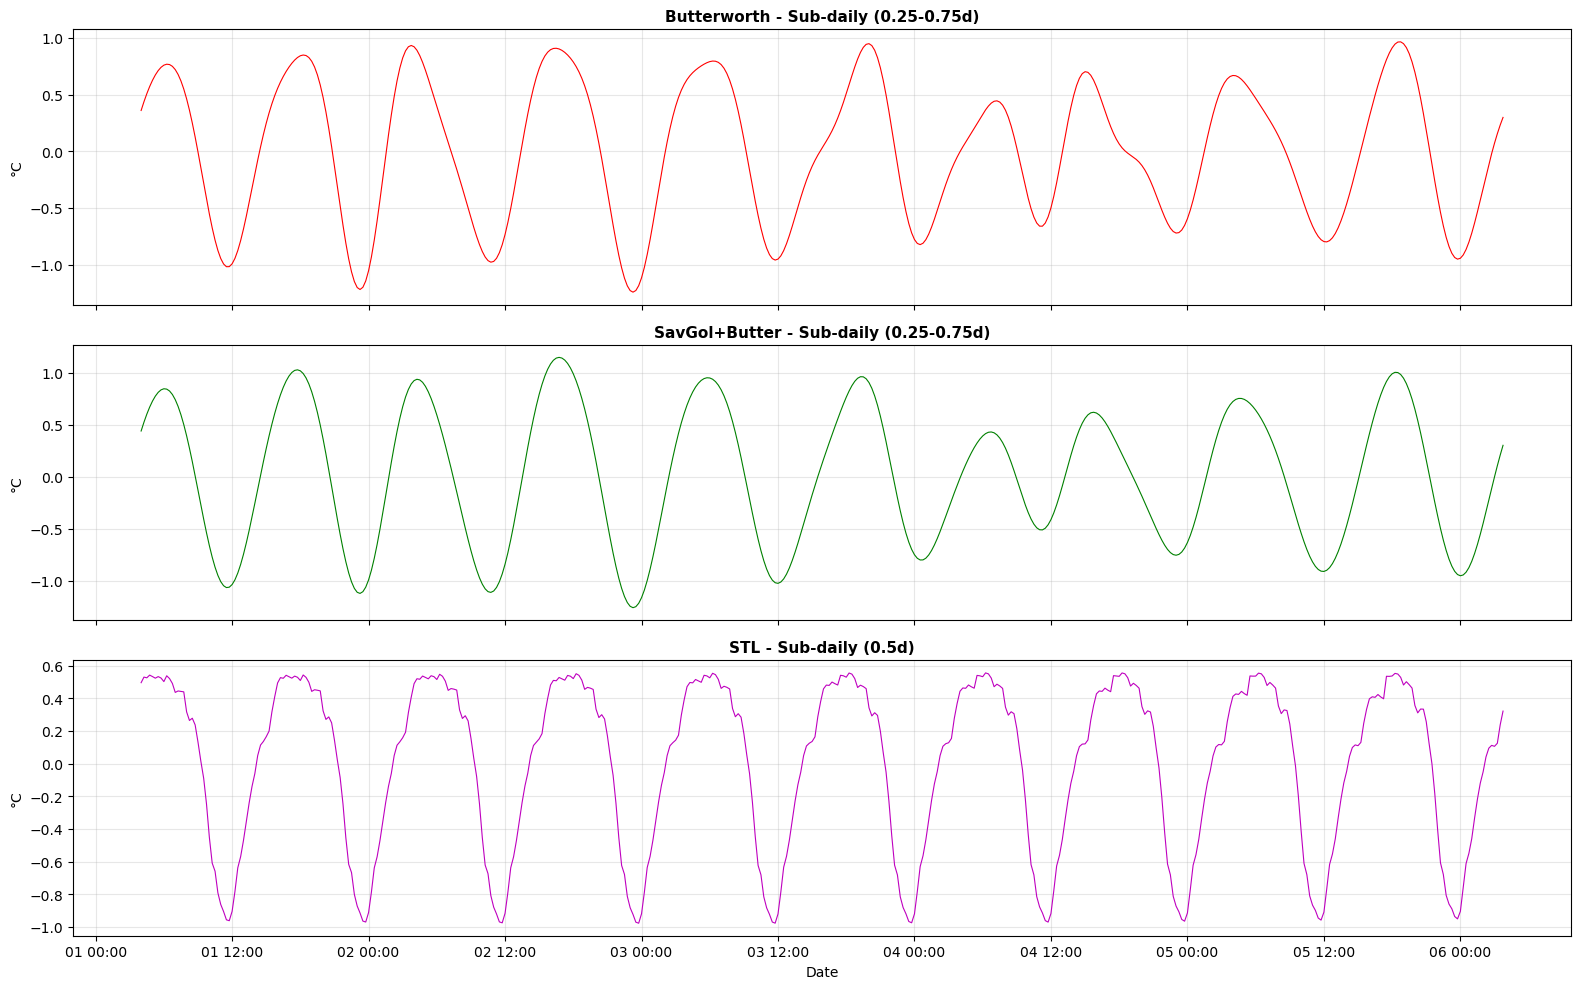

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# 5-day window for sub-daily
mask = (df_bw['ds'] >= '2024-07-01') & (df_bw['ds'] < '2024-07-06')

axes[0].plot(df_bw.loc[mask, 'ds'], df_bw.loc[mask, 'y_band_0'], 'r-', lw=0.8)
axes[0].set_title('Butterworth - Sub-daily (0.25-0.75d)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('°C')

axes[1].plot(df_sg.loc[mask, 'ds'], df_sg.loc[mask, 'y_band_0'], 'g-', lw=0.8)
axes[1].set_title('SavGol+Butter - Sub-daily (0.25-0.75d)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('°C')

axes[2].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y_period_0.5d'], 'm-', lw=0.8)
axes[2].set_title('STL - Sub-daily (0.5d)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('°C')
axes[2].set_xlabel('Date')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 12]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))

plt.tight_layout()
plt.show()

## 9. Edge Effects Analysis (Last 14 Days)

Critical for forecasting: how do methods behave at the right edge?

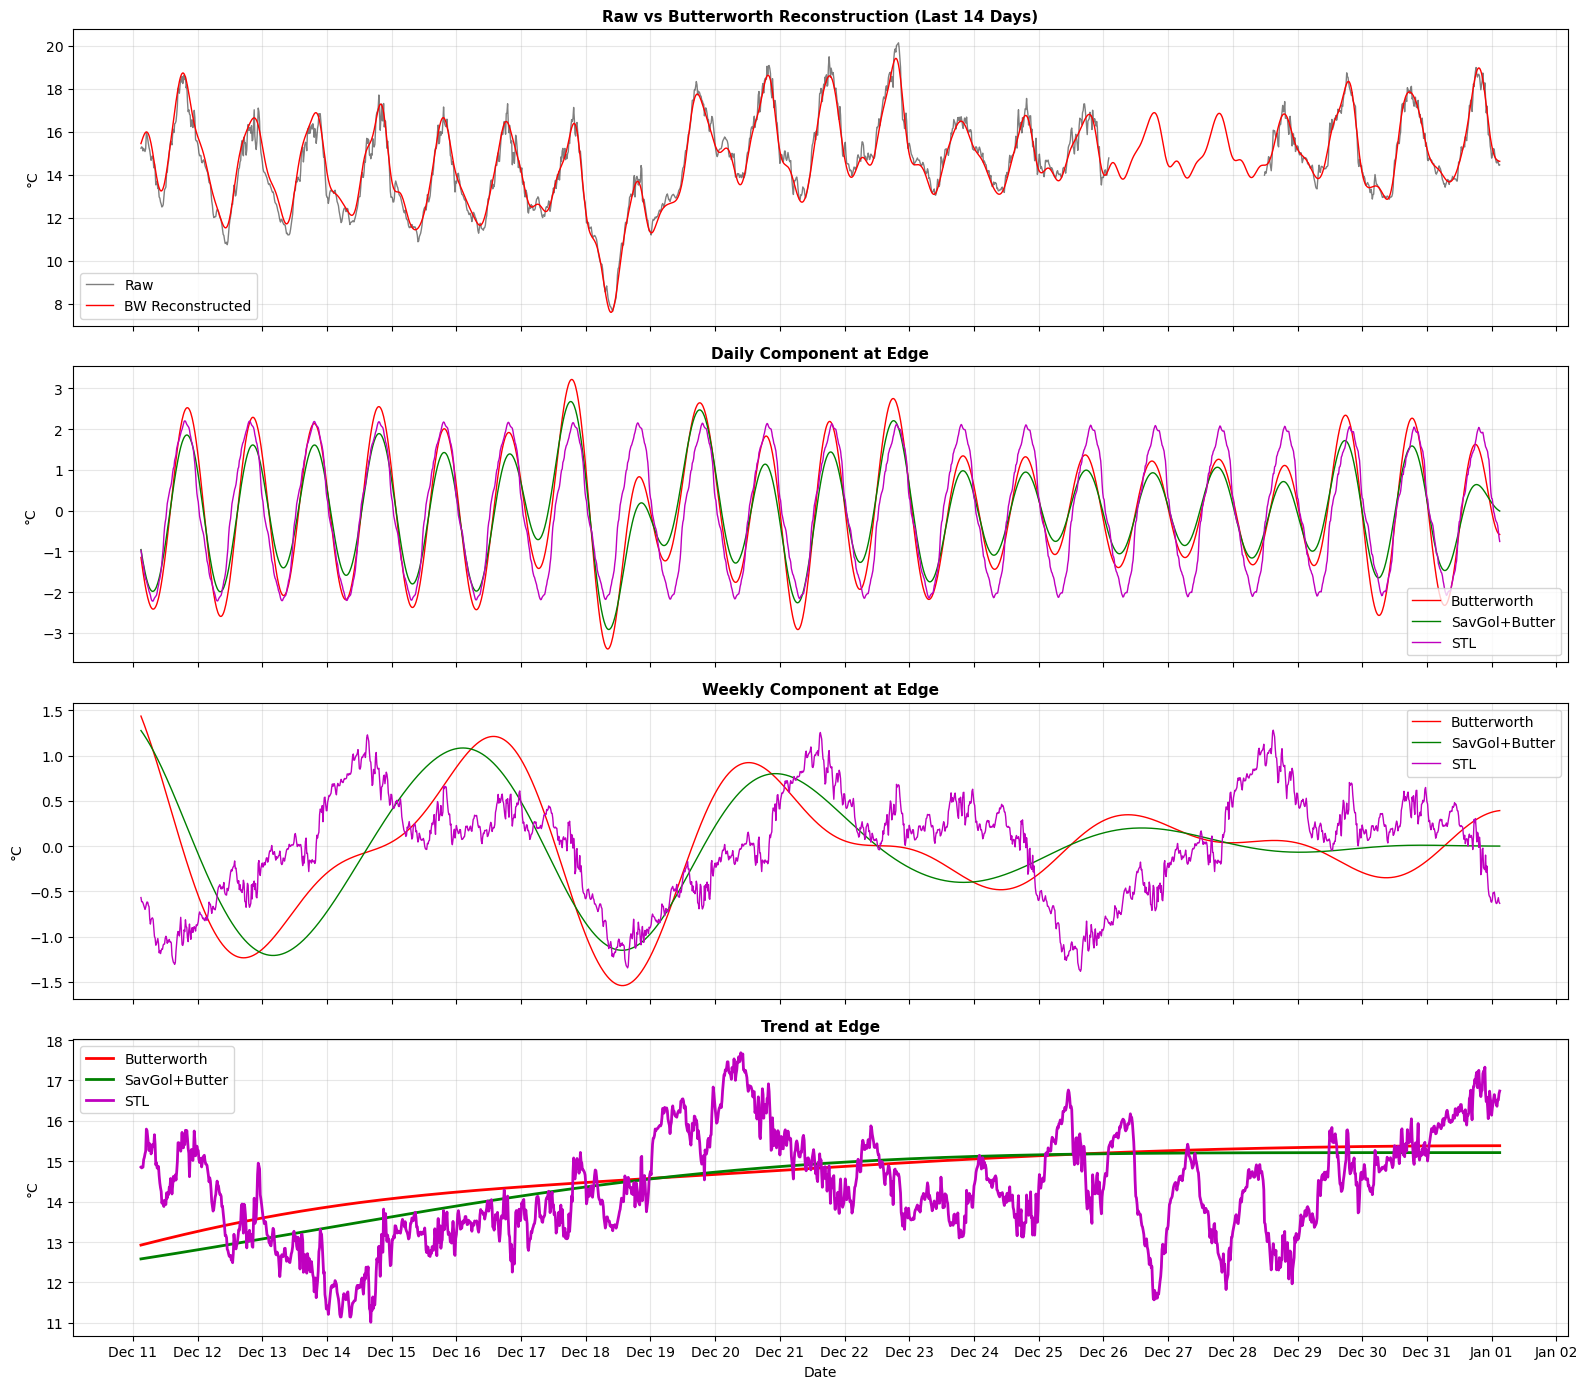

In [17]:
# Last 14 days
edge_mask = df_bw['ds'] >= (df_bw['ds'].max() - pd.Timedelta(days=21))

fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)

# Raw + reconstructed
axes[0].plot(df_bw.loc[edge_mask, 'ds'], df_bw.loc[edge_mask, 'y'], 'k-', lw=1, alpha=0.5, label='Raw')
bw_recon = df_bw.loc[edge_mask, ['y_band_0', 'y_band_1', 'y_band_2', 'y_band_3', 'y_band_4']].sum(axis=1)
axes[0].plot(df_bw.loc[edge_mask, 'ds'], bw_recon, 'r-', lw=1, label='BW Reconstructed')
axes[0].set_title('Raw vs Butterworth Reconstruction (Last 14 Days)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('°C')
axes[0].legend()

# Daily comparison at edge
axes[1].plot(df_bw.loc[edge_mask, 'ds'], df_bw.loc[edge_mask, 'y_band_1'], 'r-', lw=1, label='Butterworth')
axes[1].plot(df_sg.loc[edge_mask, 'ds'], df_sg.loc[edge_mask, 'y_band_1'], 'g-', lw=1, label='SavGol+Butter')
axes[1].plot(df_stl.loc[edge_mask, 'ds'], df_stl.loc[edge_mask, 'y_period_1.0d'], 'm-', lw=1, label='STL')
axes[1].set_title('Daily Component at Edge', fontsize=11, fontweight='bold')
axes[1].set_ylabel('°C')
axes[1].legend()

# Weekly comparison at edge
axes[2].plot(df_bw.loc[edge_mask, 'ds'], df_bw.loc[edge_mask, 'y_band_2'], 'r-', lw=1, label='Butterworth')
axes[2].plot(df_sg.loc[edge_mask, 'ds'], df_sg.loc[edge_mask, 'y_band_2'], 'g-', lw=1, label='SavGol+Butter')
axes[2].plot(df_stl.loc[edge_mask, 'ds'], df_stl.loc[edge_mask, 'y_period_7.0d'], 'm-', lw=1, label='STL')
axes[2].set_title('Weekly Component at Edge', fontsize=11, fontweight='bold')
axes[2].set_ylabel('°C')
axes[2].legend()

# Trend comparison at edge
axes[3].plot(df_bw.loc[edge_mask, 'ds'], df_bw.loc[edge_mask, 'y_band_4'], 'r-', lw=2, label='Butterworth')
axes[3].plot(df_sg.loc[edge_mask, 'ds'], df_sg.loc[edge_mask, 'y_band_4'], 'g-', lw=2, label='SavGol+Butter')
axes[3].plot(df_stl.loc[edge_mask, 'ds'], df_stl.loc[edge_mask, 'y_trend'], 'm-', lw=2, label='STL')
axes[3].set_title('Trend at Edge', fontsize=11, fontweight='bold')
axes[3].set_ylabel('°C')
axes[3].set_xlabel('Date')
axes[3].legend()

for ax in axes:
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig('real_data_decomposition.png', dpi=100)
plt.show()

## 10. All Components Overlay (STL)

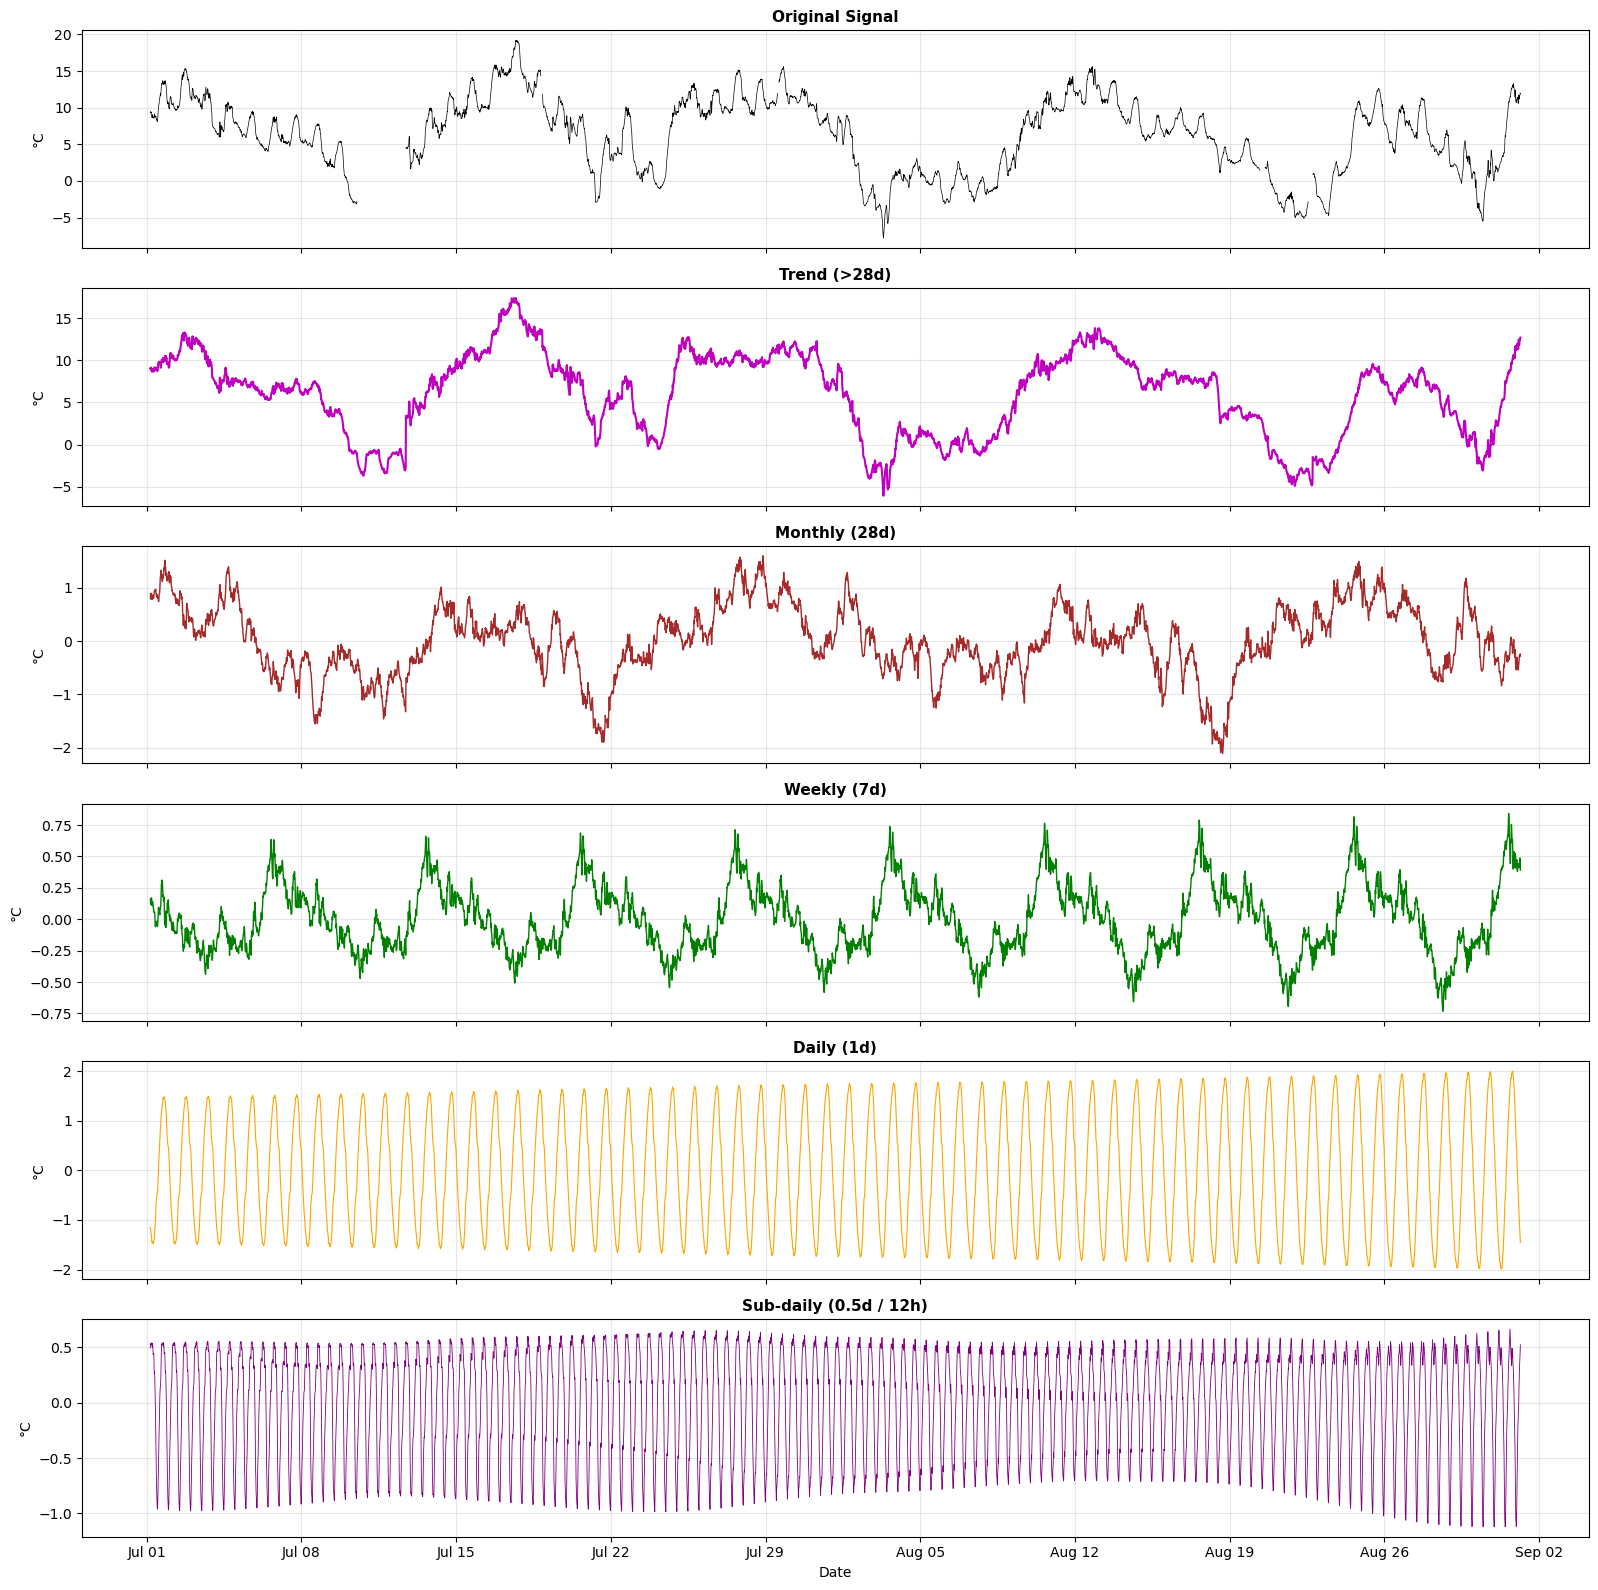

In [14]:
fig, axes = plt.subplots(6, 1, figsize=(16, 16), sharex=True)

# 2-month window
mask = (df_stl['ds'] >= '2024-07-01') & (df_stl['ds'] < '2024-09-01')

axes[0].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y'], 'k-', lw=0.5)
axes[0].set_title('Original Signal', fontsize=11, fontweight='bold')
axes[0].set_ylabel('°C')

axes[1].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y_trend'], 'm-', lw=1.5)
axes[1].set_title('Trend (>28d)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('°C')

axes[2].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y_period_28.0d'], 'brown', lw=1)
axes[2].set_title('Monthly (28d)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('°C')

axes[3].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y_period_7.0d'], 'g-', lw=1)
axes[3].set_title('Weekly (7d)', fontsize=11, fontweight='bold')
axes[3].set_ylabel('°C')

axes[4].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y_period_1.0d'], 'orange', lw=0.8)
axes[4].set_title('Daily (1d)', fontsize=11, fontweight='bold')
axes[4].set_ylabel('°C')

axes[5].plot(df_stl.loc[mask, 'ds'], df_stl.loc[mask, 'y_period_0.5d'], 'purple', lw=0.6)
axes[5].set_title('Sub-daily (0.5d / 12h)', fontsize=11, fontweight='bold')
axes[5].set_ylabel('°C')
axes[5].set_xlabel('Date')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.show()

## 11. Component Statistics

In [15]:
print("="*80)
print("COMPONENT STATISTICS (Standard Deviation)")
print("="*80)
print(f"{'Component':<20} {'Butterworth':<15} {'SavGol+Butter':<15} {'STL':<15}")
print("-"*80)

components = [
    ('Sub-daily', 'y_band_0', 'y_band_0', 'y_period_0.5d'),
    ('Daily', 'y_band_1', 'y_band_1', 'y_period_1.0d'),
    ('Weekly', 'y_band_2', 'y_band_2', 'y_period_7.0d'),
    ('Monthly', 'y_band_3', 'y_band_3', 'y_period_28.0d'),
    ('Trend', 'y_band_4', 'y_band_4', 'y_trend'),
]

for name, bw_col, sg_col, stl_col in components:
    bw_std = df_bw[bw_col].std()
    sg_std = df_sg[sg_col].std()
    stl_std = df_stl[stl_col].std()
    print(f"{name:<20} {bw_std:<15.4f} {sg_std:<15.4f} {stl_std:<15.4f}")

print("-"*80)
print(f"{'Original signal':<20} {df['y'].std():<15.4f}")
print("="*80)

COMPONENT STATISTICS (Standard Deviation)
Component            Butterworth     SavGol+Butter   STL            
--------------------------------------------------------------------------------
Sub-daily            0.6181          0.6538          0.4787         
Daily                1.5881          1.3296          1.2817         
Weekly               1.3741          1.2662          0.3424         
Monthly              2.3369          2.2081          1.0864         
Trend                4.5388          4.3237          5.3347         
--------------------------------------------------------------------------------
Original signal      5.5281         


## 12. Reconstruction Quality

In [16]:
# Reconstruction
bw_recon = df_bw[['y_band_0', 'y_band_1', 'y_band_2', 'y_band_3', 'y_band_4']].sum(axis=1)
sg_recon = df_sg[['y_band_0', 'y_band_1', 'y_band_2', 'y_band_3', 'y_band_4']].sum(axis=1)
stl_recon = df_stl[['y_period_0.5d', 'y_period_1.0d', 'y_period_7.0d', 'y_period_28.0d', 'y_trend']].sum(axis=1)

# Fill NaN in original for comparison
y_filled = df['y'].ffill().bfill()

print("Reconstruction Error (vs filled original):")
print(f"  Butterworth MSE:    {np.nanmean((bw_recon - y_filled)**2):.6f}")
print(f"  SavGol+Butter MSE:  {np.nanmean((sg_recon - y_filled)**2):.6f}")
print(f"  STL MSE:            {np.nanmean((stl_recon - y_filled)**2):.6f}")

Reconstruction Error (vs filled original):
  Butterworth MSE:    0.607122
  SavGol+Butter MSE:  1.573534
  STL MSE:            0.000000


## 13. Conclusions

### Observations

1. **Trend**: All methods capture the seasonal temperature variation (cold in winter, warm in summer)

2. **Daily cycle**: Strong diurnal pattern visible in all methods. STL produces cleaner, more consistent daily cycles.

3. **Weekly/Monthly**: These are weather-driven (cold fronts, storms) rather than truly periodic. Methods show different sensitivities.

4. **Edge effects**: 
   - Butterworth shows some edge artifacts, especially in longer-period components
   - STL handles edges more gracefully
   - Reflect padding helps all methods

### Recommendations

For temperature forecasting:
- **STL** is recommended for its robustness and cleaner component separation
- Use `robust=True` if data has outliers
- The daily component (1.0d) is the most reliable periodic signal
- Weekly/monthly components capture weather variability, not true periodicity